In [5]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [7]:
from google.colab import files

print("--- Step 1: Upload Dataset ---")
# This will prompt you to select the file from your computer
uploaded = files.upload()

# Get the filename of what you just uploaded
zip_filename = next(iter(uploaded))
print(f"Uploaded: {zip_filename}")

--- Step 1: Upload Dataset ---


Saving Cat_Species_Dataset_All.zip to Cat_Species_Dataset_All.zip
Uploaded: Cat_Species_Dataset_All.zip


In [8]:
# 2. Unzip and Prepare Data
# ==========================================
extract_path = "./dataset_extracted"
print(f"\nUnzipping {zip_filename}...")
!unzip -q -o "{zip_filename}" -d {extract_path}

# Find the folder containing the class subfolders
data_root = extract_path
for root, dirs, files in os.walk(extract_path):
    if len(dirs) >= 2:
        data_root = root
        break

print(f"Data found at: {data_root}")

# Setup Data Loaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(root=data_root, transform=transform)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Unzipping Cat_Species_Dataset_All.zip...
Data found at: ./dataset_extracted
Using device: cuda


In [15]:
# 2. Data Loading with AUGMENTATION
# ==========================================
# This is the "Secret Sauce" to fix low accuracy
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),    # Randomly flip images
    transforms.RandomRotation(10),        # Randomly rotate
    transforms.ColorJitter(brightness=0.1), # Change lighting slightly
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Test data should remain plain
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Helper to apply different transforms to split data
class TransformSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform: x = self.transform(x)
        return x, y
    def __len__(self): return len(self.subset)

# Load and Split
full_dataset = datasets.ImageFolder(root=data_root)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_idx, test_idx = random_split(full_dataset, [train_size, test_size])

# Apply Augmentation ONLY to Training set
train_dataset = TransformSubset(train_idx, transform=train_transform)
test_dataset = TransformSubset(test_idx, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} (Classes: {full_dataset.classes})")

Using device: cuda (Classes: ['Abyssinian', 'American_Shorthair', 'Asian_Golden_Cat', 'Bengal_Cat', 'Birman', 'Black-footed_Cat', 'Bobcat', 'Bombay_Cat', 'British_Shorthair', 'Caracal', 'Cheetah', 'Clouded_Leopard', 'Devon_Rex', 'Eurasian_Lynx', 'Exotic_Shorthair', 'Fishing_Cat', 'Himalayan_Cat', 'Jaguar', 'Jaguarundi', 'Leopard', 'Lion', 'Maine_Coon', 'Manx_Cat', 'Margay', 'Norwegian_Forest_Cat', 'Ocelot', 'Pallas_Cat', 'Persian_Cat', 'Puma', 'Ragdoll', 'Russian_Blue', 'Sand_Cat', 'Savannah_Cat', 'Scottish_Fold', 'Scottish_Wildcat', 'Serval', 'Siamese_Cat', 'Siberian_Cat', 'Snow_Leopard', 'Sphynx', 'Tiger'])


In [16]:
# 3. Define Models (Improved Architecture)
# ==========================================

# --- Improved Custom Model (Deeper + Batch Norm) ---
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            # Block 2
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            # Block 3
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            # Block 4 (Extra layer for better learning)
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5), # Helps prevent overfitting
            nn.Linear(512, num_classes)
        )
    def forward(self, x): return self.classifier(self.features(x))

# --- Training Loop ---
def train_model(model, name, epochs=15):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    # Use smaller learning rate for stability
    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    print(f"\nTraining {name} for {epochs} epochs...")
    loss_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        loss_history.append(avg_loss)
        # Print every epoch to see progress
        print(f"  Epoch {epoch+1}/{epochs}: Loss = {avg_loss:.4f}", end="\r")

    # Evaluate
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print(f"\n  {name} Final Accuracy: {acc:.2f}%")
    return acc, loss_history

In [17]:
# 4. Run Training & Compare
# ==========================================

# 1. Train Improved Custom Model (Increased epochs to 15)
acc_custom, loss_custom = train_model(ImprovedCNN(len(full_dataset.classes)), "Improved Custom CNN", epochs=15)

# 2. Train ResNet50
resnet = models.resnet50(pretrained=True)
for param in resnet.parameters(): param.requires_grad = False
resnet.fc = nn.Linear(resnet.fc.in_features, len(full_dataset.classes))
acc_resnet, loss_resnet = train_model(resnet, "ResNet50", epochs=15)


Training Improved Custom CNN for 15 epochs...

  Improved Custom CNN Final Accuracy: 20.73%

Training ResNet50 for 15 epochs...

  ResNet50 Final Accuracy: 80.49%


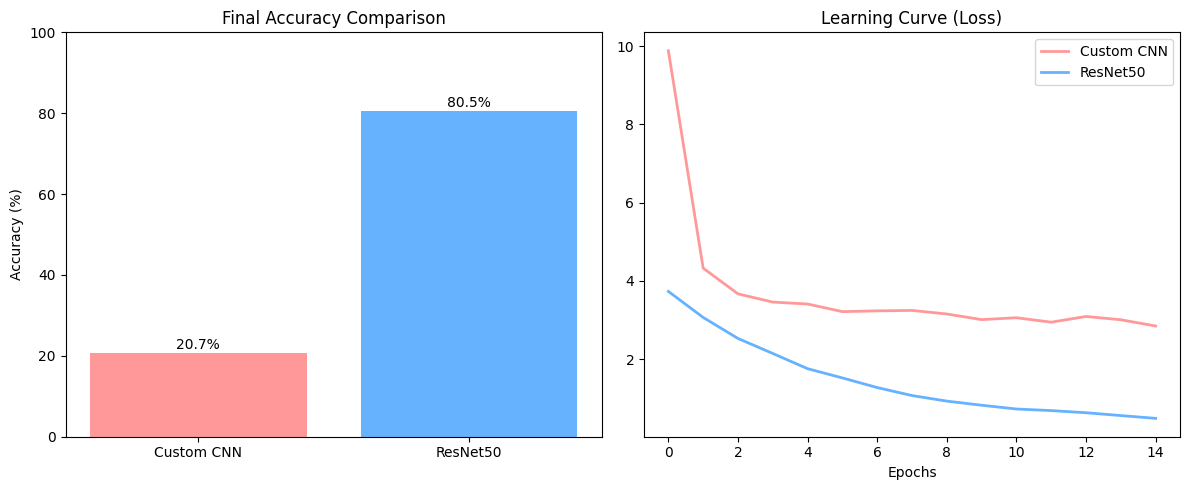

In [18]:
# 5. Final Plot
# ==========================================
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
bars = plt.bar(['Custom CNN', 'ResNet50'], [acc_custom, acc_resnet], color=['#FF9999', '#66B2FF'])
plt.title('Final Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+1, f'{bar.get_height():.1f}%', ha='center')

# Loss
plt.subplot(1, 2, 2)
plt.plot(loss_custom, label='Custom CNN', color='#FF9999', linewidth=2)
plt.plot(loss_resnet, label='ResNet50', color='#66B2FF', linewidth=2)
plt.title('Learning Curve (Loss)')
plt.xlabel('Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [20]:
# 5. Few-Shot Learning Evaluation
# ==========================================
print("\n--- Step 5: Few-Shot Learning Evaluation ---")

# A. Prepare Feature Extractor (ResNet50 without the final classification layer)
# We want the raw "knowledge" (embeddings) from the pre-trained model
feature_extractor = models.resnet50(pretrained=True)
feature_extractor = nn.Sequential(*list(feature_extractor.children())[:-1]) # Remove 'fc' layer
feature_extractor = feature_extractor.to(device)
feature_extractor.eval() # Set to evaluation mode (frozen)

# B. Helper to extract embeddings from images
def get_embeddings(loader, model):
    embeddings = []
    labels_list = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            # Forward pass to get features
            features = model(inputs)
            # Flatten: (Batch_Size, 2048, 1, 1) -> (Batch_Size, 2048)
            features = features.flatten(start_dim=1)

            embeddings.append(features.cpu().numpy())
            labels_list.append(labels.numpy())

    return np.vstack(embeddings), np.concatenate(labels_list)

print("Extracting features from Training and Test sets...")
# Get features (vectors) for Train (Support Set) and Test (Query Set)
X_train_feats, y_train_labels = get_embeddings(train_loader, feature_extractor)
X_test_feats, y_test_labels = get_embeddings(test_loader, feature_extractor)

print(f"  Features extracted. Train shape: {X_train_feats.shape}, Test shape: {X_test_feats.shape}")

# C. Perform Classification using Nearest Neighbor (Prototypical approach)
# We use k=1 to find the single closest match in the training set
print("Running Nearest Neighbor Classifier on embeddings...")
few_shot_classifier = KNeighborsClassifier(n_neighbors=1, metric='cosine')
few_shot_classifier.fit(X_train_feats, y_train_labels)

# Predict on Test set
y_pred_fs = few_shot_classifier.predict(X_test_feats)
acc_few_shot = accuracy_score(y_test_labels, y_pred_fs) * 100

print(f"  Few-Shot (Frozen ResNet) Accuracy: {acc_few_shot:.2f}%")


--- Step 5: Few-Shot Learning Evaluation ---


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracting features from Training and Test sets...
  Features extracted. Train shape: (328, 2048), Test shape: (82, 2048)
Running Nearest Neighbor Classifier on embeddings...
  Few-Shot (Frozen ResNet) Accuracy: 80.49%



--- Step 6: Final Comparison Graph ---


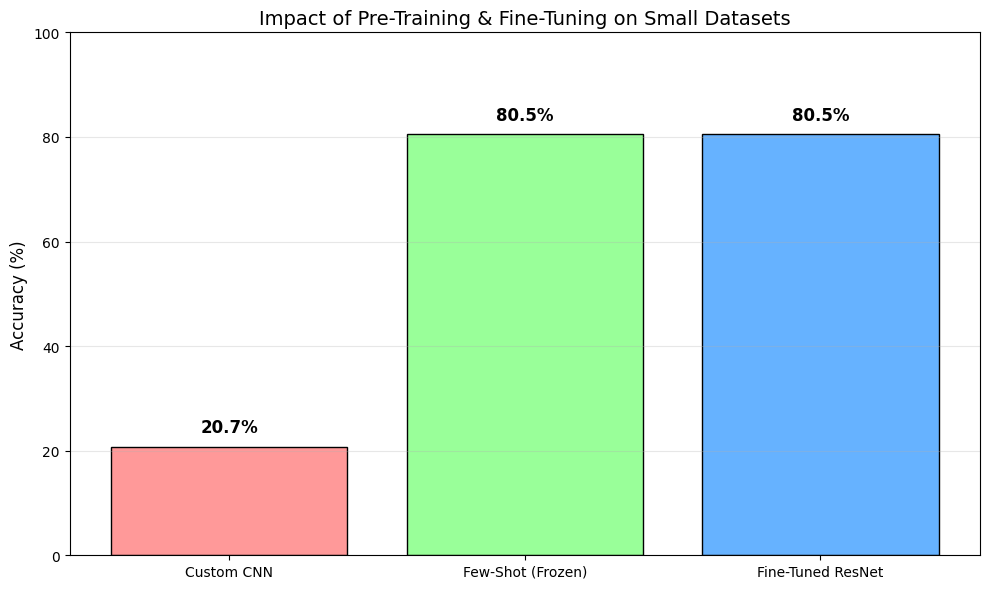

In [21]:
# 6. Final Visualization (3-Way Comparison)
# ==========================================
print("\n--- Step 6: Final Comparison Graph ---")

# List of models and their accuracies
# acc_custom and acc_resnet should be available from your previous cells
models_list = ['Custom CNN', 'Few-Shot (Frozen)', 'Fine-Tuned ResNet']
accuracies = [acc_custom, acc_few_shot, acc_resnet]

plt.figure(figsize=(10, 6))
# Colors: Red (Custom), Yellow/Green (Few-Shot), Blue (Transfer Learning)
bars = plt.bar(models_list, accuracies, color=['#FF9999', '#99FF99', '#66B2FF'], edgecolor='black')

plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Impact of Pre-Training & Fine-Tuning on Small Datasets', fontsize=14)
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3)

# Add percentage labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, f'{yval:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()